## Try on our OCTCube classification model!

In [1]:
import os
import torch
import monai
import argparse
import numpy as np
import pydicom as dcm
import matplotlib.pyplot as plt

from OCTCube.util.PatientDataset_inhouse import create_3d_transforms
from inference_utils import create_models, parse_all_output, process_dicom_array, disease_abbreviation

/home/tienyuchang/.local/lib/python3.10/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module
Protobuf gencode version 5.28.1 is exactly one major version older than the runtime version 6.31.1 at api.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
Importing from timm.models.helpers is deprecated, please import via timm.models
Importing from timm.models.layers is deprecated, please import via timm.layers


In [2]:
disease_list = {
    'Normal': 0,
    'Diabetic macular edema': 1,
    'Age-related macular degeneration': 2,
    'Primary Open-Angle Glaucoma': 3,
    'Epiretinal Membrane': 4,
    'Diabetic Retinopathy': 5,
    'Vitreous Degeneration': 6,
    'Retinal Vein / Artery Occlusion': 7,
    'Retinal Neovascularization': 8,
}
# inversed_disease_list = {v: k for k, v in disease_list.items()}

#### Config the model

In [3]:
def get_args_parser():
    disease_classes = 8
    parser = argparse.ArgumentParser('OCTCube Model Loader', add_help=False)
    parser.add_argument('--model', default='flash_attn_vit_large_patch16', type=str, help='Model name')
    parser.add_argument('--model_type', default='3D_st_flash_attn', type=str, help='Model type')
    parser.add_argument('--ckpt', default='ckpt/OCTCube_multitask_cls.pth', type=str, help='Checkpoint path, the default is a multi-task model trained on 8 diseases')
    parser.add_argument('--t_patch_size', default=3, type=int, help='Temporal patch size')
    parser.add_argument('--num_frames', default=48, type=int, help='Number of frames, the default is 48')
    parser.add_argument('--input_size', default=256, type=int, help='Input size')
    parser.add_argument('--nb_classes', default=2*disease_classes, type=int, help='Number of classes')
    parser.add_argument('--drop_path', default=0.2, type=float, help='Drop path rate')
    parser.add_argument('--global_pool', action='store_true', help='Global average pooling')
    parser.set_defaults(global_pool=True)
    parser.add_argument('--sep_pos_embed', action='store_true', help='Use separate positional embeddings')
    parser.set_defaults(sep_pos_embed=True)
    parser.add_argument("--cls_embed", action="store_true")
    parser.add_argument("--device", default="cuda:0", type=str)
    parser.set_defaults(cls_embed=True)

    return parser

args = get_args_parser().parse_args([])
print('args:', args)

# Create transformas
_, val_transforms = create_3d_transforms(input_size=args.input_size, num_frames=args.num_frames, RandFlipd_prob=0, RandRotate90d_prob=0, normalize_dataset=False)


args: Namespace(model='flash_attn_vit_large_patch16', model_type='3D_st_flash_attn', ckpt='ckpt/OCTCube_multitask_cls.pth', t_patch_size=3, num_frames=48, input_size=256, nb_classes=16, drop_path=0.2, global_pool=True, sep_pos_embed=True, cls_embed=True, device='cuda:0')


monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [4]:
# Create and load the model
model = create_models(args)
model.to(args.device)

softmax = torch.nn.Softmax(dim=2)


Use 3D spatio-temporal model w/ flash attention
{'num_frames': 48, 't_patch_size': 3, 'img_size': 256, 'patch_size': 16, 'in_chans': 1, 'num_classes': 16, 'qk_scale': None, 'drop_path_rate': 0.2, 'dropout': 0.5, 'sep_pos_embed': True, 'cls_embed': True, 'global_pool': True, 'kwargs': {'use_flash_attention': True}, 'attn_drop_rate': 0.0, 'depth': 24, 'drop_rate': 0.0, 'embed_dim': 1024, 'mlp_ratio': 4, 'no_qkv_bias': False, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'num_heads': 16, 'self': VisionTransformer(), 'use_flash_attn': True, '__class__': <class 'OCTCube.models_vit_st_flash_attn.VisionTransformer'>}
img_size (256, 256) patch_size (16, 16) frames 48 t_patch_size 3


FileNotFoundError: [Errno 2] No such file or directory: 'ckpt/OCTCube_multitask_cls.pth'

#### Load our provided examples

In [28]:
# Seletecting the data
disease_idx = 7
# oct_example_list = os.listdir('assets/oct_examples')
oct_example_list = ['VD.dcm', 'RNV.dcm', 'POAG.dcm', 'ERM.dcm', 'AMD.dcm', 'DR.dcm', 'DME.dcm', 'CRAO.dcm']
print('Example data:', oct_example_list)
dataname = oct_example_list[disease_idx]
disease_name = dataname.split(".")[0]
print(f'Picking {disease_name} from {dataname}!')



data_sample = os.path.join('assets/oct_examples', oct_example_list[disease_idx])

Example data: ['VD.dcm', 'RNV.dcm', 'POAG.dcm', 'ERM.dcm', 'AMD.dcm', 'DR.dcm', 'DME.dcm', 'CRAO.dcm']
Picking CRAO from CRAO.dcm!


In [29]:
data = dcm.dcmread(data_sample, force=True)
dicom_array = data.pixel_array
print('original dicom array shape:', dicom_array.shape)

tensor, tensor_shape = process_dicom_array(dicom_array, val_transform=val_transforms)
tensor = tensor / 255
print('processed tensor shape:', tensor_shape, '\n')


original dicom array shape: (60, 496, 768)
(60, 496, 768)
processed tensor shape: torch.Size([1, 48, 256, 256]) 



#### Run the inference

In [30]:
# Run the inference
with torch.no_grad():
    with torch.cuda.amp.autocast():
        pred = model(tensor.unsqueeze(0).cuda())
        pred = pred.reshape(1, -1, 2)
    pred = softmax(pred)


print(data_sample)
print(parse_all_output(pred[0].cpu().numpy()))

assets/oct_examples/CRAO.dcm
Disease probability: (Disease Name: Probability) 
Normal: 0.138        DME: 0.360       AMD: 0.862       POAG: 0.321       EPM: 0.514       DR: 0.639       VD: 0.571       RAO\RVO: 0.612       RNV: 0.701       


#### Visualize the images

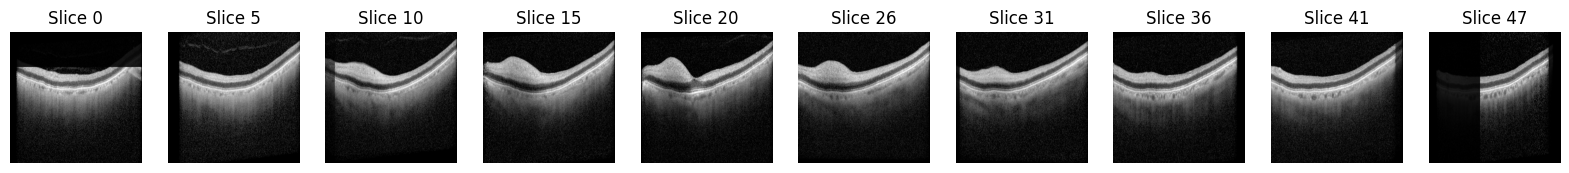

In [34]:
num_of_slices_to_show = 10
num_of_slices = tensor.shape[1]
slices_to_show = np.linspace(0, num_of_slices-1, num_of_slices_to_show).astype(int)
fig, ax = plt.subplots(1, num_of_slices_to_show, figsize=(20, 2))

for i, idx in enumerate(slices_to_show):
    ax[i].imshow(tensor[0, idx, :, :], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Slice {slices_to_show[i]}')

plt.show()

#### See the gradient saliency (Coming soon, stay tuned...) 